# Rozpoznawanie obrazu na potrzeby eksperymentu naukowego

Pi of the Sky (https://www.pi.fuw.edu.pl/jest) jest eksperymentem astrofizycznym, którego głównym celem jest poszukiwanie rozbłysków gamma (GRB) (https://pl.wikipedia.org/wiki/Rozbłysk_gamma). W tym celu zautomatyzowane teleskopy w Chile i Hiszpanii fotografują niebo w poszukiwaniu interesujących zdarzeń. Klasyczne algorytmy wykrywania rozbłysków gamma działają w następujący sposób: wybrany obszar nieba jest stale fotografowany w pewnych odstępach czasu, jeżeli skanowany obszar zmieni się w jakiś sposób, może to oznaczać, iż pojawiło się nowe źródło promieniowania, dlatego kilka(naście) klatek (zdjęć) przed i po wystąpieniu zjawiska jest zachowywanych do późniejszej analizy. Naukowcy analizują sekwencję zdjęć aby stwierdzić, czy faktycznie zaobserwowano rozbłysk gamma. Niestety, wiele spośród zebranych danych to fałszywe alarmy, wywołane np. przez chmury poruszające się na niebie. Poniżej stworzony został algorytm uczenia maszynowego oparty o konwolucyjne sieci neuronowe, który mógłby usprawnić analizę poprzez odsiewanie niepoprawnych danych, oszczędzając pracy naukowcom.

Zadanie stanowi tzw. "proof of concept", czyli rozwiązanie dalekie od ostatecznego, ale pokazujące, że problem może potencjalnie zostać rozwiązany z użyciem zaproponowanej metody. Dokonana została klasyfikacjia obrazów należących do trzech klas:

0) zdjęcia potencjalnie zawierające rozbłyski gamma 

1) fałszywe alarmy przedstawiające niebo z chmurami

2) fałszywe alarmy zawierające artefakty spowodowane wadliwą pracą aparatury badawczej (poziome/pionowe linie)

#### Pobranie danych i rozpakowanie

In [ ]:
! wget https://github.com/Rav2/uczenie-maszynowe-2021-22/raw/main/praca_domowa/data.zip
! unzip -q data.zip

--2022-02-06 16:35:50--  https://github.com/Rav2/uczenie-maszynowe-2021-22/raw/main/praca_domowa/data.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Rav2/uczenie-maszynowe-2021-22/main/praca_domowa/data.zip [following]
--2022-02-06 16:35:50--  https://raw.githubusercontent.com/Rav2/uczenie-maszynowe-2021-22/main/praca_domowa/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14050616 (13M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  13.40M  --.-KB/s    in 0.06s   

2022-02-06 16:35:50 (208 MB/s) - ‘data.zip’ saved [14050616/14050616]



# Wczytanie i wstępna obróbka danych

Import bibliotek i funkcji

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tabulate import tabulate

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow import keras
from tensorflow.keras.layers import *

from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Tworzę, na razie wypełnione zerami, tablice: tensor cech oraz wektor etykiet.

In [ ]:
tensor = np.zeros((3573, 100, 100))
y = np.zeros(3573)

W pętli konwertuję obrazy na talicę i dodaję to do tensora cech oraz na podstawie folderu, w którym znajdowały się poszczególne zdjęcia tworzę etykietę. Pomijam przykład, który nie jest rozpoznawany jako zdjęcie przez program.

In [ ]:
ind = 0

for j in range(3):
  files = os.listdir(f'data/{j}/')
  for i in range(len(files)):
    if files[i] == '.DS_Store':
      continue
    path = os.path.join(f'data/{j}/', files[i])
    img = load_img(path, color_mode='grayscale')
    img_arr = np.asarray(img)
    tensor[ind] = img_arr
    y[ind] = j
    ind += 1

Sprawdzam wymiar tensora. Brakuje w nim kanałów, więc je dodaję.

In [ ]:
print('Wymiar tensora cech przed korektą:   ', tensor.shape)

Wymiar tensora cech przed korektą:    (3573, 100, 100)


In [ ]:
tensor = tensor.reshape(tensor.shape+(-1,))

In [ ]:
print('Wymiar tensora cech po korekcie:   ', tensor.shape)

Wymiar tensora cech po korekcie:    (3573, 100, 100, 1)


Sprawdzam liczebność klas

In [ ]:
klasa_0 = 0
klasa_1 = 0
klasa_2 = 0

for i in y:
  if i == 0:
    klasa_0 += 1
  elif i == 1:
    klasa_1 +=1
  elif i == 2:
    klasa_2 +=1

print('Liczebność klasy 0:   ', klasa_0)
print('Liczebność klasy 1:   ', klasa_1)
print('Liczebność klasy 2:   ', klasa_2)

Liczebność klasy 0:    1978
Liczebność klasy 1:    706
Liczebność klasy 2:    889


Wypisuję wymiary obrazka i zapisuję je jako zmienne x i y.

In [ ]:
files_0 = os.listdir('data/0/')
path_0 = os.path.join('data/0/', files_0[1])
img_0 = load_img(path_0, color_mode='grayscale')
img_arr_0 = np.asarray(img_0)

Y = img_arr_0.shape[0]
X = img_arr_0.shape[1]

print('Wymiary obrazka:  ', X, 'x', Y)

Wymiary obrazka:   100 x 100


Obrazy z poszczególnych klas:

Text(0.5, 1.0, 'Obraz z klasy 2')

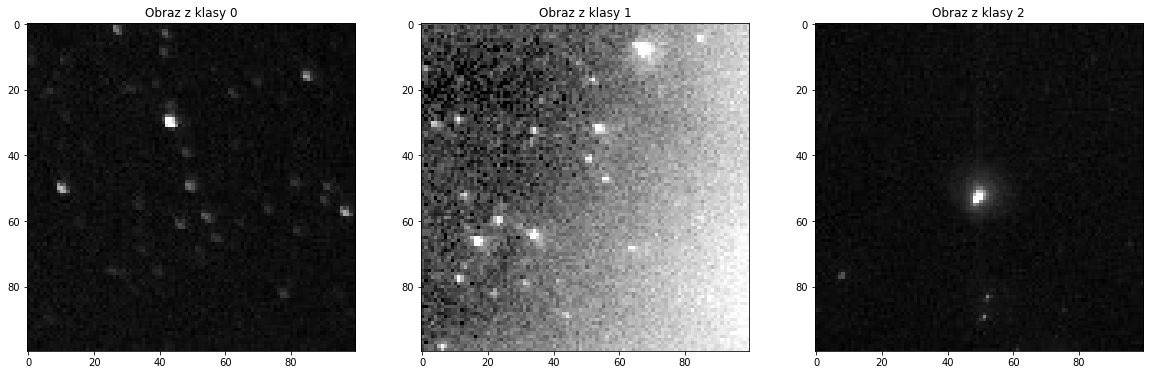

In [ ]:
files_1 = os.listdir('data/1/')
path_1 = os.path.join('data/1/', files_1[1])
img_1 = load_img(path_1, color_mode='grayscale')

files_2 = os.listdir('data/2/')
path_2 = os.path.join('data/2/', files_2[1])
img_2 = load_img(path_2, color_mode='grayscale')


plt.figure(figsize = (20,10))
plt.subplot(1,3,1)
plt.imshow(img_0, cmap='gray')
plt.title('Obraz z klasy 0')

plt.subplot(1,3,2)
plt.imshow(img_1, cmap='gray')
plt.title('Obraz z klasy 1')

plt.subplot(1,3,3)
plt.imshow(img_2, cmap='gray')
plt.title('Obraz z klasy 2')

# Preprocessing

Skaluję wartości pikseli tak, aby znajdowały się one w przedziale od 0 do 1.

In [ ]:
maxValue = np.amax(tensor)
tensor = tensor / maxValue

Dzielę dane na zbiór treningowy i uczący.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tensor, y, test_size = 0.3)

Sprawdzam, czy rozkład klas jest podobny w zbiorze testowym i uczącym.

In [ ]:
d = [["Procentowy rozkład klas w zbiorze uczącym", np.sum(y_train==0)/np.shape(y_train)[0], np.sum(y_train==1)/np.shape(y_train)[0], np.sum(y_train==2)/np.shape(y_train)[0]],
     ["Procentowy rozkład klas w zbiorze testowym", np.sum(y_test==0)/np.shape(y_test)[0], np.sum(y_test==1)/np.shape(y_test)[0], np.sum(y_test==2)/np.shape(y_test)[0]]]

print(tabulate(d, headers=["", "Klasa 0", "Klasa 1", "Klasa 2"]))

                                              Klasa 0    Klasa 1    Klasa 2
------------------------------------------  ---------  ---------  ---------
Procentowy rozkład klas w zbiorze uczącym    0.552579   0.20112    0.246301
Procentowy rozkład klas w zbiorze testowym   0.55597    0.189366   0.254664


# Uczenie sieci

Definiuję kilka potrzebnych funkcji:

In [ ]:
def plotTrainingHistory(model):

    fig, axes= plt.subplots(1,2,figsize=(10,5))
    history = model.history
    axes[0].plot(history['accuracy'])
    axes[0].plot(history['val_accuracy'])
    axes[0].set_ylabel('accuracy')
    axes[0].set_xlabel('epoch')
    axes[0].legend(['train', 'validation'], loc='upper left')

    axes[1].plot(history['loss'])
    axes[1].plot(history['val_loss'])
    axes[1].set_ylabel('loss function')
    axes[1].set_xlabel('epoch')
    axes[1].legend(['train', 'validation'], loc='upper left')

In [ ]:
def printScores(model, X, Y):
    Y_pred = np.argmax(model.predict(X), axis=1) 
    print("Classification report:")
    print(classification_report(Y,Y_pred))
    print("Confusion matrix:")
    print(confusion_matrix(Y, Y_pred))

In [ ]:
def plotExamples(model, data, labels):
    fig, axes= plt.subplots(3,3,figsize=(10,10))
    for k, ax in zip(range(axes.size), axes.reshape(-1)):
        ax.imshow(data[k,:,:,0].reshape(100,100), cmap='gray', interpolation='none')
        Y_pred = model.predict(data[k:k+1,:,:,:])
        Y_pred = np.argmax(Y_pred, axis=1)[0]   
        Y_true = np.argmax(labels[k])              
        ax.set_title("Predicted={}, True={}".format(Y_pred, Y_true))

Zmieniam etykiety na reprezentację "one hot encoding".

In [ ]:
depth = 3

Y_train = tf.one_hot(y_train, depth)
Y_test = tf.one_hot(y_test, depth)

Ustalam parametry:

In [ ]:
nFilters = 32
kernel_size = 3
pool_size = (2,2)
nNeurons = 128 
nHiddenLayers = 1 
inputShape = (X, Y, 1)
outputWidth = 3
epochs = 15
batch_size = 128

Architektura sieci:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 49, 49, 32)        0         
                                                                 
 flatten (Flatten)           (None, 76832)             0         
                                                                 
 dense (Dense)               (None, 128)               9834624   
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                        

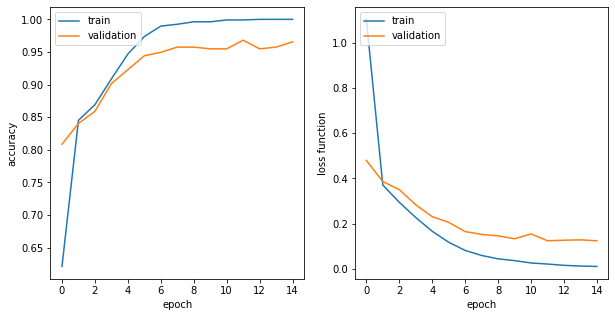

In [ ]:
def getModel(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, dropout_rate, inputShape, outputWidth):
      
    model = keras.Sequential()
    model.add(Input(shape = inputShape))

    for iHidden in range(nHiddenLayers):   
        model.add(Conv2D(filters=nFilters, kernel_size=kernel_size, activation=tf.nn.relu))
        model.add(MaxPooling2D(pool_size=pool_size))
        model.add(Dropout(dropout_rate))
  
    model.add(Flatten())
    model.add(Dense(nNeurons, activation=tf.nn.relu))
    model.add(Dense(outputWidth, activation=tf.nn.softmax))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

dropout_rate = 0.2

model = getModel(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, dropout_rate, inputShape, outputWidth)
model.summary()
model_h = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.15, verbose=0)
plotTrainingHistory(model_h)

# Ewaluacja

Wykonuję predykcję na zbiorze testowym. Na jej podstawie wypisuję raport z klasyfikacji i macierz pomyłek.

In [ ]:
printScores(model, X_test, np.argmax(Y_test, axis=1)) 

Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       596
           1       0.99      0.97      0.98       203
           2       0.97      0.96      0.97       273

    accuracy                           0.98      1072
   macro avg       0.98      0.98      0.98      1072
weighted avg       0.98      0.98      0.98      1072

Confusion matrix:
[[594   0   2]
 [  0 197   6]
 [  9   2 262]]


Na podstawie wyników z macierzy pomyłek wyrysowuję histogram zawierający procentową zawartość prawidłowych klasyfikacji względem liczebności klasy.
Najgorzej wypada klasa 2.

In [ ]:
Y_pred = model.predict(X_test)
arr = confusion_matrix(np.argmax(Y_test, axis=1), Y_pred.argmax(axis=1))
per_00 = arr[0,0]/np.sum(arr[0])*100 #procent klasy 0 sklasyfikowanej jako klasa 0
per_11 = arr[1,1]/np.sum(arr[1])*100 #procent klasy 1 sklasyfikowanej jako klasa 1
per_22 = arr[2,2]/np.sum(arr[2])*100 #procent klasy 2 sklasyfikowanej jako klasa 2

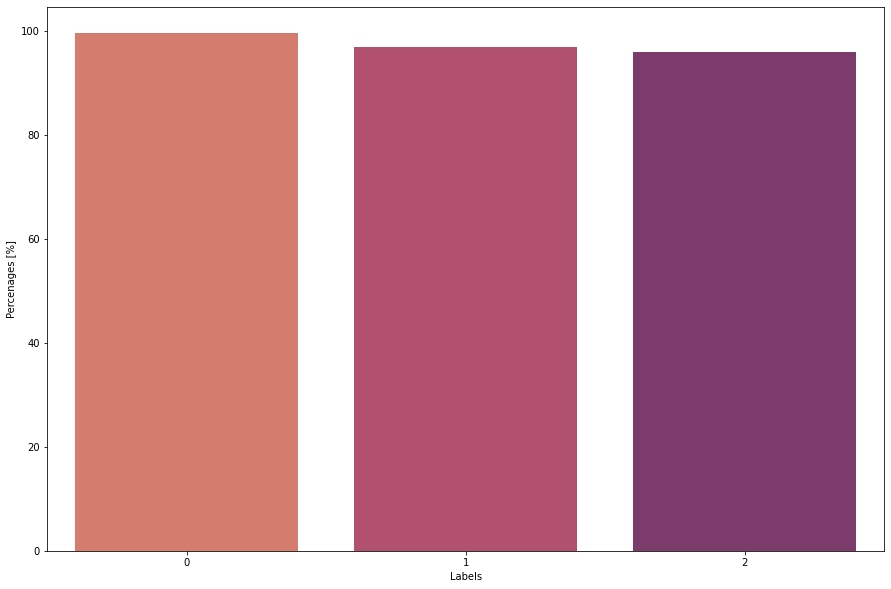

In [ ]:
df = pd.DataFrame({'labels': [0, 1, 2], 'percentages': [per_00, per_11, per_22]})

plt.figure(figsize = (15,10))
ax = sns.barplot(x = 'labels', y = 'percentages', data = df, palette="flare")
ax.set(xlabel='Labels', ylabel='Percenages [%]')
plt.show()

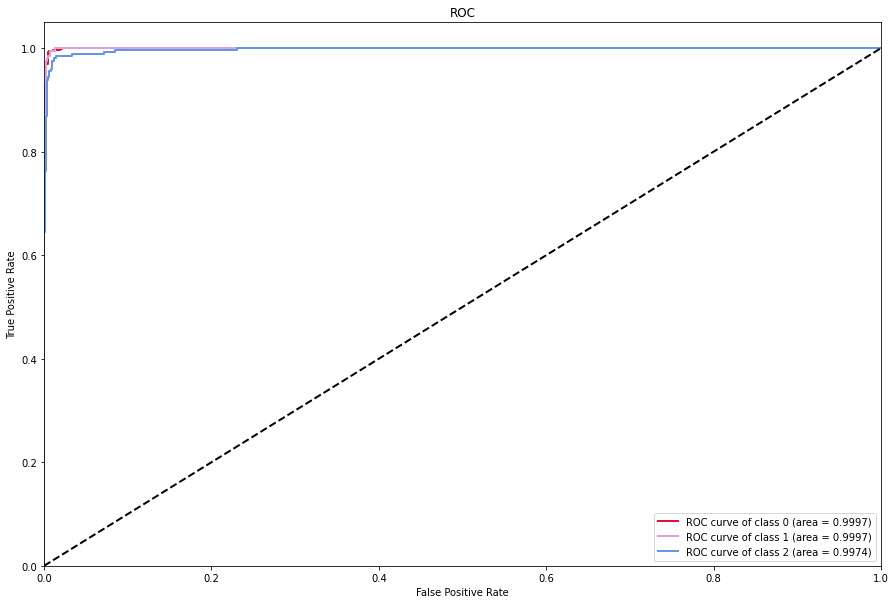

In [ ]:
n_classes = 3
y_t = label_binarize(Y_test, classes=[0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_t[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (15,10))

colors = ["crimson", "plum", "cornflowerblue"]
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),)

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend(loc="lower right")
plt.show()

#Generacja pseudodanych

Tworzyę obiekt typu ImageDataGenerator z parametrami:
* przesunięcia o nie wiecej niż 20 pikseli 
* odbicia względem osi OX lub OY 
* zoom do 10%

15% zbioru treningowego przeznaczam na zbiór walidacyjny.

In [ ]:
DataGenerator = keras.preprocessing.image.ImageDataGenerator(width_shift_range = 20, height_shift_range = 20, zoom_range = 0.1, horizontal_flip = True, vertical_flip = True, validation_split = 0.15)

In [ ]:
model_DG = getModel(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, dropout_rate, inputShape, outputWidth)

Trenuję sieć z wykorzystaniem metody "flow".

In [ ]:
model_DG_h = model_DG.fit(DataGenerator.flow(X_train, Y_train, batch_size=batch_size, subset = 'training'), validation_data = DataGenerator.flow(X_train, Y_train, batch_size = int(batch_size/4),subset = 'validation'), batch_size = batch_size, epochs = epochs)

Epoch 1/15
17/17 [==============================] - 3s 150ms/step - loss: 0.9131 - accuracy: 0.6750 - val_loss: 0.4373 - val_accuracy: 0.8293
Epoch 2/15
17/17 [==============================] - 2s 135ms/step - loss: 0.4459 - accuracy: 0.8128 - val_loss: 0.4110 - val_accuracy: 0.8240
Epoch 3/15
17/17 [==============================] - 2s 137ms/step - loss: 0.4184 - accuracy: 0.8175 - val_loss: 0.4088 - val_accuracy: 0.8320
Epoch 4/15
17/17 [==============================] - 2s 136ms/step - loss: 0.4056 - accuracy: 0.8302 - val_loss: 0.3966 - val_accuracy: 0.8347
Epoch 5/15
17/17 [==============================] - 2s 134ms/step - loss: 0.3975 - accuracy: 0.8274 - val_loss: 0.3993 - val_accuracy: 0.8373
Epoch 6/15
17/17 [==============================] - 2s 134ms/step - loss: 0.3940 - accuracy: 0.8293 - val_loss: 0.3828 - val_accuracy: 0.8400
Epoch 7/15
17/17 [==============================] - 2s 135ms/step - loss: 0.3782 - accuracy: 0.8405 - val_loss: 0.3756 - val_accuracy: 0.8347
Epoch 

Ewaluacja:

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 49, 49, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 76832)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               9834624   
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                      

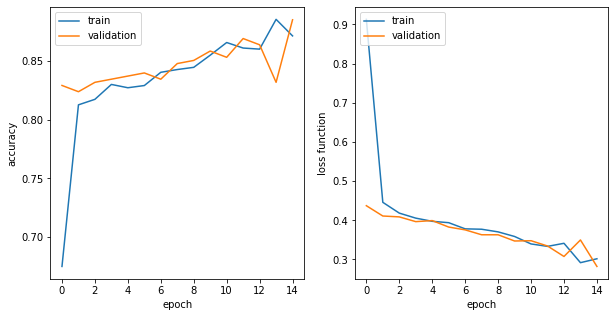

In [ ]:
model_DG.summary()
plotTrainingHistory(model_DG_h)

In [ ]:
printScores(model_DG, X_test, np.argmax(Y_test, axis=1)) 

Classification report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       596
           1       0.97      0.96      0.97       203
           2       0.88      0.26      0.41       273

    accuracy                           0.80      1072
   macro avg       0.87      0.74      0.74      1072
weighted avg       0.83      0.80      0.76      1072

Confusion matrix:
[[595   0   1]
 [  0 194   9]
 [196   5  72]]


In [ ]:
Y_pred_DG = model_DG.predict(X_test)
arr_DG = confusion_matrix(np.argmax(Y_test, axis=1), Y_pred_DG.argmax(axis=1))
per_00_DG = arr_DG[0,0]/np.sum(arr_DG[0])*100 #procent klasy 0 sklasyfikowanej jako klasa 0
per_11_DG = arr_DG[1,1]/np.sum(arr_DG[1])*100 #procent klasy 1 sklasyfikowanej jako klasa 1
per_22_DG = arr_DG[2,2]/np.sum(arr_DG[2])*100 #procent klasy 2 sklasyfikowanej jako klasa 2

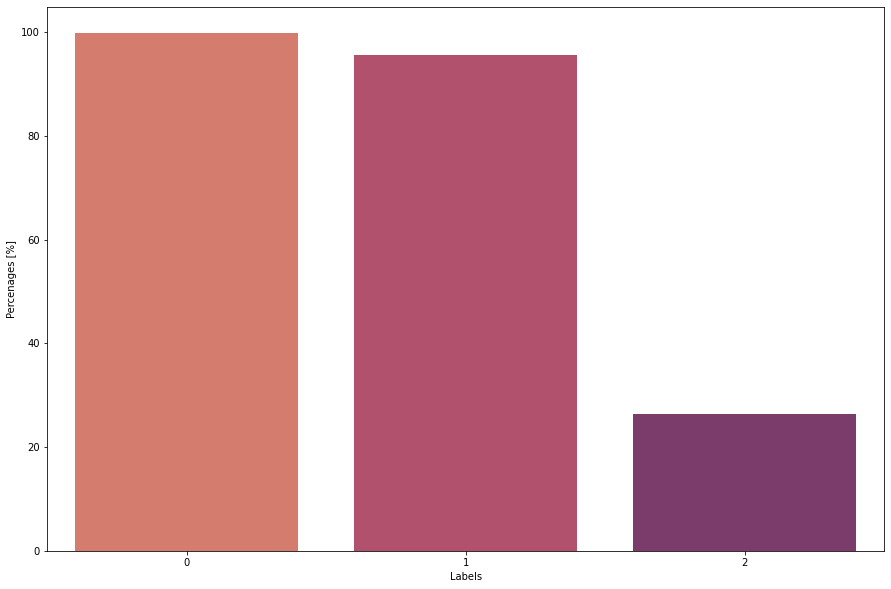

In [ ]:
df_DG = pd.DataFrame({'labels': [0, 1, 2], 'percentages': [per_00_DG, per_11_DG, per_22_DG]})

plt.figure(figsize = (15,10))
ax = sns.barplot(x = 'labels', y = 'percentages', data = df_DG, palette="flare")
ax.set(xlabel='Labels', ylabel='Percenages [%]')
plt.show()

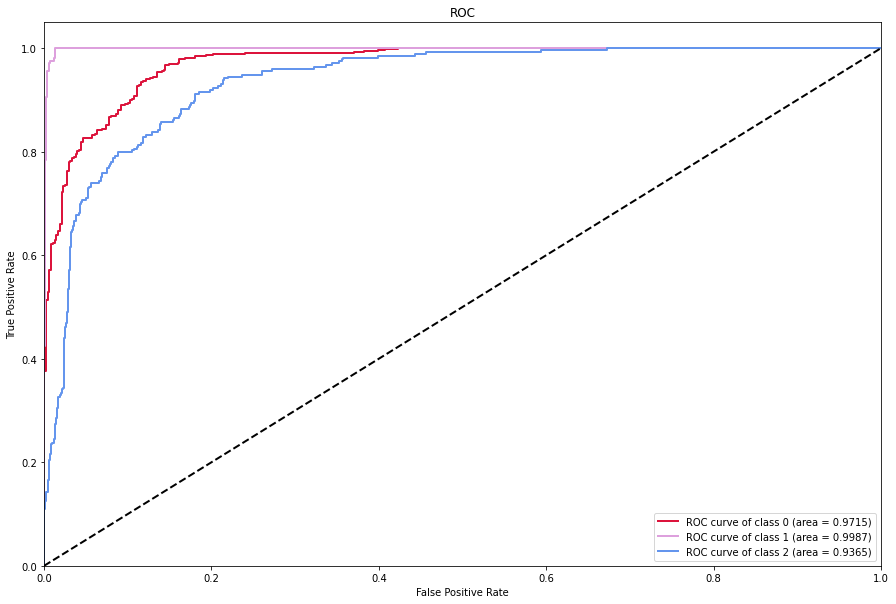

In [ ]:
n_classes = 3
y_t_DG = label_binarize(Y_test, classes=[0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_t_DG[:, i], Y_pred_DG[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (15,10))

colors = ["crimson", "plum", "cornflowerblue"]
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),)

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend(loc="lower right")
plt.show()

Wyniki dla modelu z pseudodanymi wypadają gorzej niż bez nich. Dla każdej klasy spadł procent danych poprawnie sklasyfikowanych. Szczególnie dużą różnicę widać dla klasy 2. Jeśli wyświetli się kilka obrazków z tej klasy widać pojawiający się artefakt w postaci pionowej kreski (można to zobaczyć na obrazach poniżej). Możliwe, że model uczy się, że obraz należy do klasy 2 rozpoznając charakterystyczną kreskę na środku. W takim wypadku zmiany wprowadzone na obrazie mogą sprawiać, że kreska znajdzie się w innym miejscu lub będzie zniekształcona. Z inaczej wyglądającym artefaktem, obrazy w dużej mierze mogą przypominać te z klasy 0, więc większość z nich jest właśnie w ten sposób sklasyfikowana. Różnica w wynikach na histogramach wydaje się drastycznie różna od różnicy w wynikach na krzywej ROC. Podczas gdy na histogramie słupek dla klasy 2 bardzo maleje dla pseudodanych to krzywa ROC, mimo że jest gorsza, to nadal jest zadowalająca. Wynika to z tego, że są to różne miary oceny modelu i mają różny charakter.

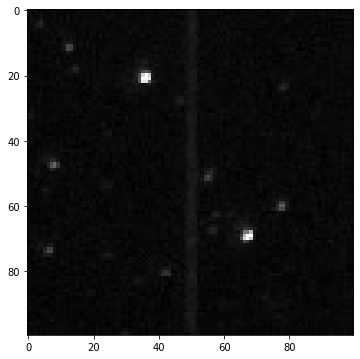

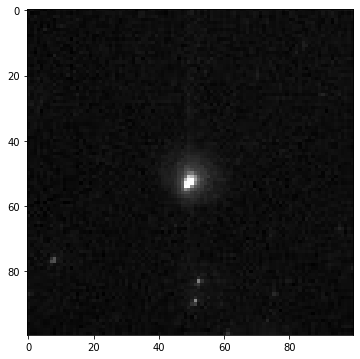

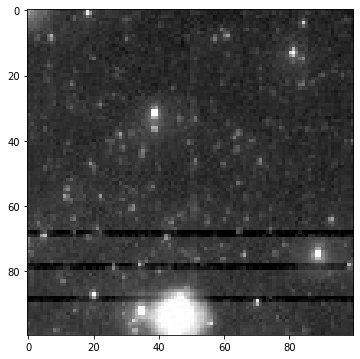

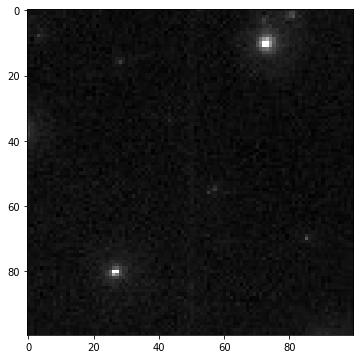

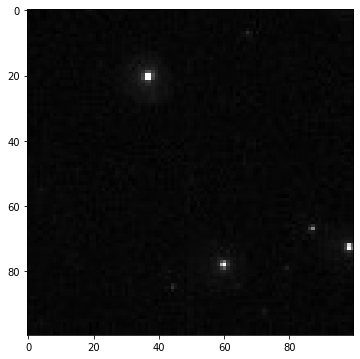

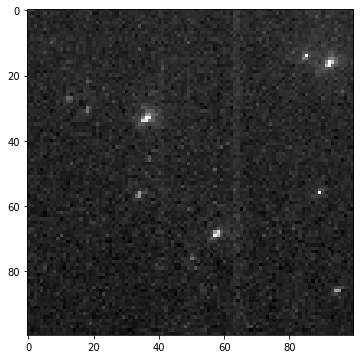

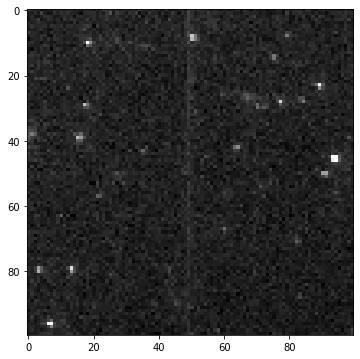

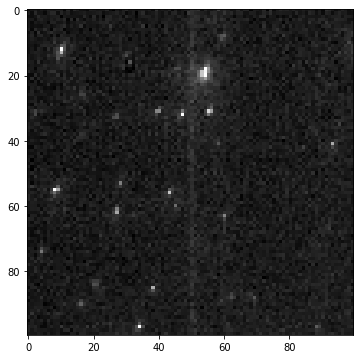

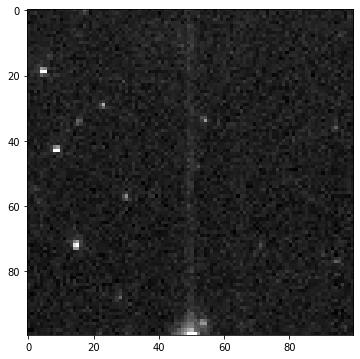

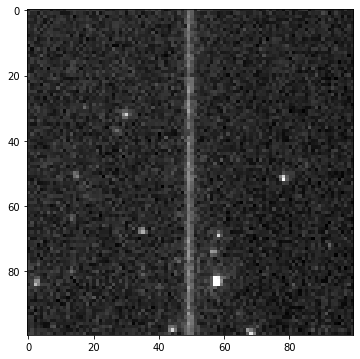

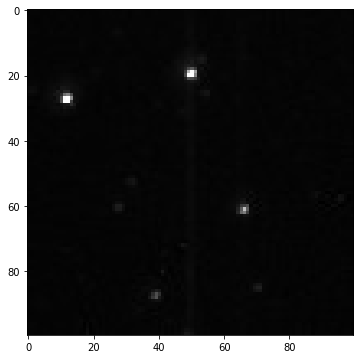

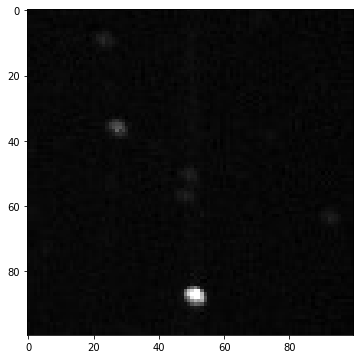

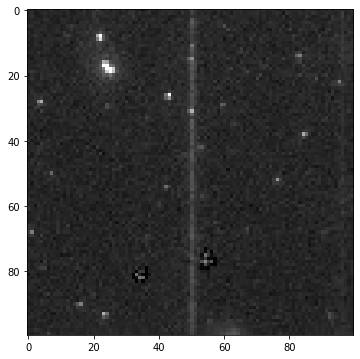

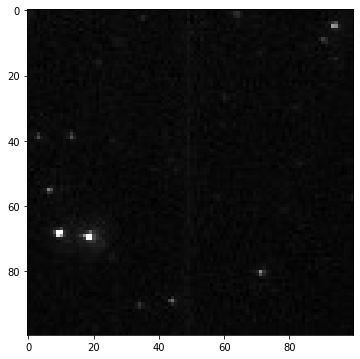

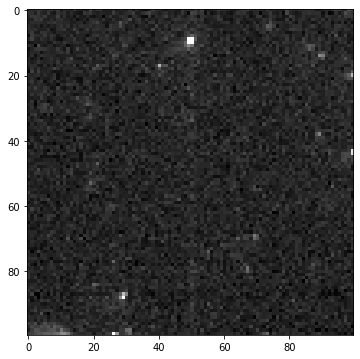

In [ ]:
for i in range(15):
  path_2 = os.path.join('data/2/', files_2[i])
  img_2 = load_img(path_2, color_mode='grayscale')
  plt.figure(figsize = (10,6))
  plt.imshow(img_2, cmap='gray')